In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
os.chdir('../../../../')
print(os.getcwd())
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll



/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [2]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config
model = Trading(load_config())
dataset_list = []
for d in model.dfs:
    print(d[1])
    cur_dataset = d[0]
    my_inds = fetchIndicators(["rsi", "macd", "stochastic_oscillator", "optimal_v2", 'slope', 'variance', 'bollinger_bands', 'pivot_points'])
    genDataForAll(cur_dataset, my_inds)
    cur_dataset.dropna(inplace=True)
    mm_scalar = MinMaxScaler()
    cur_dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d"]])
    dataset_list.append(cur_dataset)
final_dataset = pd.concat(dataset_list)



XBTUSD


In [3]:
def insert_buys(close, prediction):
    if prediction == 1:
        return close
    else:
        return None

def insert_sells(close, prediction):
    if prediction == -1:
        return close
    else:
        return None

In [6]:
bear_model = pickle.load(open('./v2/strategy/saved_models/optimal_v2_buy_rf.sav', 'rb'))
bull_model = pickle.load(open('./v2/strategy/saved_models/optimal_v2_sell_rf.sav', 'rb'))

bear_data = final_dataset[["rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]
bull_data = final_dataset[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]

final_dataset['predict_bull'] = bull_model.predict(bull_data)
final_dataset['predict_bear'] = bear_model.predict(bear_data)

final_dataset['bull'] = final_dataset.apply(lambda x: insert_sells(x.close, x.predict_bull), axis=1)
final_dataset['bear'] = final_dataset.apply(lambda x: insert_buys(x.close, x.predict_bear), axis=1)

reset_filtered = final_dataset.reset_index(drop=True)
reset_filtered['count'] = reset_filtered['bull'].rolling(60).count() - reset_filtered['bear'].rolling(60).count()


In [27]:
first_amnt = reset_filtered[0:4000]

<Figure size 432x288 with 0 Axes>

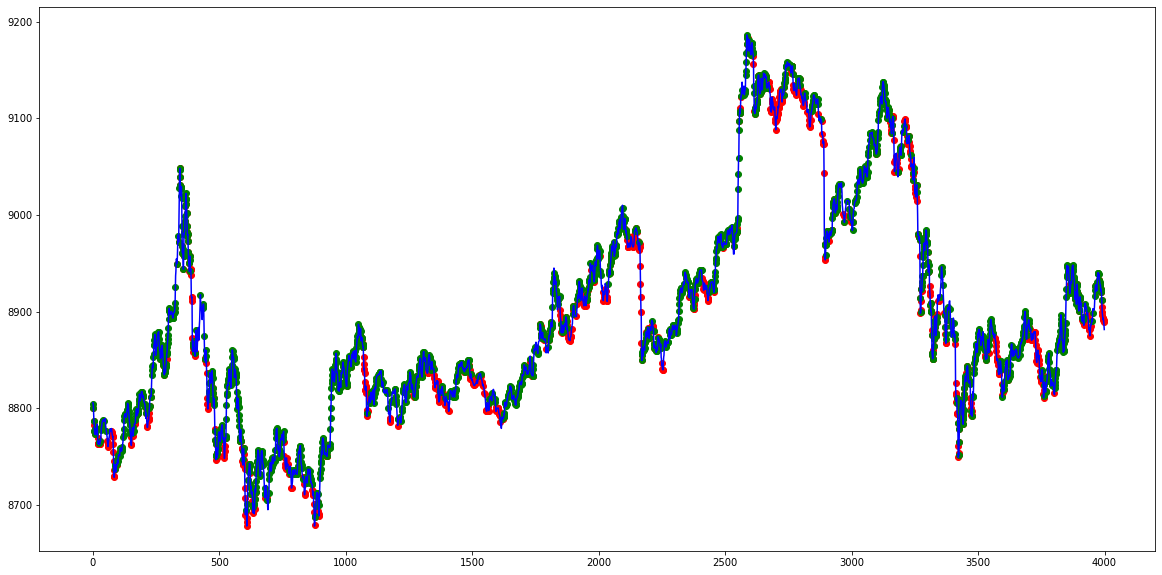

In [28]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=first_amnt.index, y=first_amnt['bear'], color='red')
plt.scatter(x=first_amnt.index, y=first_amnt['bull'], color='green')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()

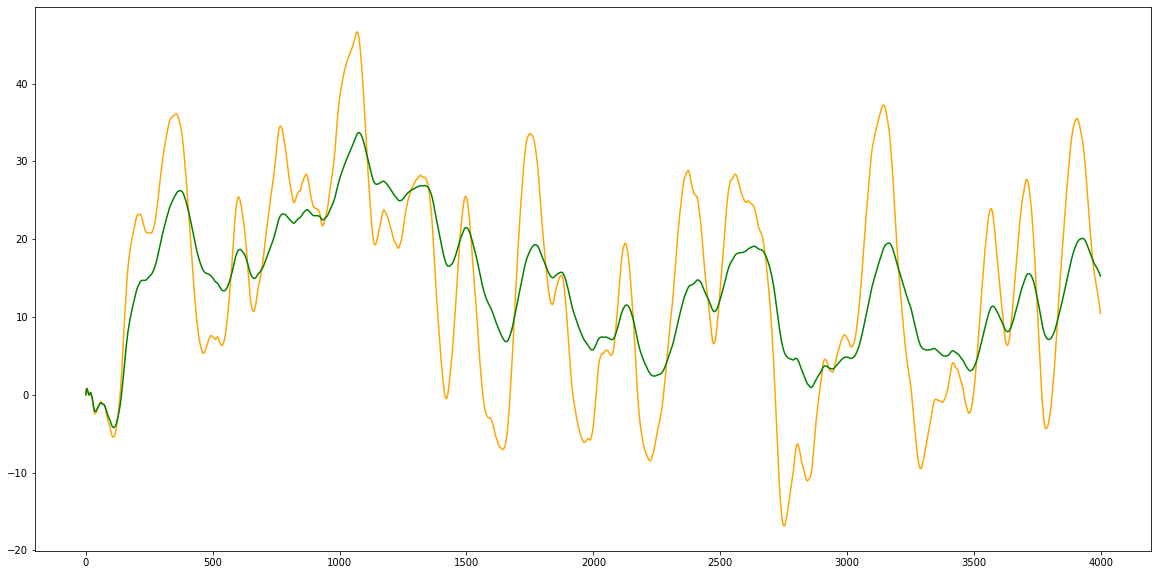

In [32]:
plt.figure(figsize=(20,10))
# plt.plot(first_amnt.index, first_amnt['count'].rolling(240).mean(), color='purple')
# plt.plot(first_amnt.index, first_amnt['count'].rolling(1440).mean(), color='blue')
plt.plot(first_amnt.index, first_amnt['count'].ewm(60).mean(), color='orange')
plt.plot(first_amnt.index, first_amnt['count'].ewm(120).mean(), color='green')
plt.show()